# Analysis of raw data from tactile and vision

1. Test preprocessing and make changes
2. Number of spikes

In [38]:
4*5*40

800

In [1]:
import pandas as pd
import numpy as np
import os
import logging
import datetime
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import Parallel, delayed
from pathlib import Path
from collections import namedtuple

In [2]:
selections = {  # index, offset, length
    "full": [1, 0.0, 8.5],
    "reaching": [1, 0.0, 2.0],
    "grasp": [3, 0.0, 4.0],
    "lift": [4, 0.0, 0.75],
    "hold": [4, 2.0, 1.25],
    "lift_hold": [4, 0.0, 2.0],
    "grasp_lift": [3, 0.0, 4.75],
    "grasp_lift_hold": [3, 0.0, 6.5]
}

In [3]:
Trajectory = namedtuple(
    "Trajectory", ["start", "reaching", "reached", "grasping", "lifting", "holding"]
)

In [4]:
def read_trajectory(trajectory_path, obj_name, start_time=None, zeroed=False):
    """Reads the trajectory from path, Returns a Trajectory."""
    obj_path = Path(trajectory_path) / f"{obj_name}.startend"
    with open(obj_path, "r") as f:
        timings = list(map(float, f.read().split(" ")))
        if start_time is not None:
            delta = start_time - timings[0]
            timings = [t + delta for t in timings]
        if zeroed:
            start_time = timings[0]
            timings = [t - start_time for t in timings]
        return Trajectory(*timings)

In [5]:
def read_tactile_file(tactile_path, obj_name):
    """Reads a tactile file from path. Returns a pandas dataframe."""
    obj_path = Path(tactile_path) / f"{obj_name}.tact"
    df = pd.read_csv(
        obj_path,
        delimiter=" ",
        names=["polarity", "cell_index", "timestamp"],
        dtype={'polarity': int, 'cell_index': int, 'timestamp': float}
    )
    return df




In [6]:
class TactileData:
    def __init__(self, obj_name, selection):
        assert selection in selections
        self.obj_name = obj_name
        self.trajectory = read_trajectory(trajectory_path, obj_name)
        self.df = read_tactile_file(tactile_path, obj_name)

        traj_start, offset, self.T = selections[selection]
        self.start_t = self.trajectory[traj_start] + offset
        self.threshold = 1

    def binarize(self, bin_duration):
        bin_number = int(np.floor(self.T / bin_duration))
        data_matrix = np.zeros([80, 2, bin_number], dtype=int)

        pos_df = self.df[self.df.polarity == 1]
        neg_df = self.df[self.df.polarity == 0]

        end_t = self.start_t + bin_duration
        count = 0

        init_t = self.start_t

        while end_t <= self.T + init_t:  # start_t <= self.T
            _pos_count = pos_df[
                ((pos_df.timestamp >= self.start_t) & (pos_df.timestamp < end_t))
            ]
            _pos_selective_cells = _pos_count.cell_index.value_counts() > self.threshold
            if len(_pos_selective_cells):
                data_matrix[
                    _pos_selective_cells[_pos_selective_cells].index.values - 1,
                    0,
                    count,
                ] = 1

            _neg_count = neg_df[
                ((neg_df.timestamp >= self.start_t) & (neg_df.timestamp < end_t))
            ]
            _neg_selective_cells = _neg_count.cell_index.value_counts() > self.threshold
            if len(_neg_selective_cells):
                data_matrix[
                    _neg_selective_cells[_neg_selective_cells].index.values - 1,
                    1,
                    count,
                ] = 1
            self.start_t = end_t
            end_t += bin_duration
            count += 1

        data_matrix = np.delete(data_matrix, [16, 48], 0)
        return data_matrix

In [7]:
# batch2
list_of_objects2 = [
    "107-a_pepsi_bottle",
    "107-b_pepsi_bottle",
    "107-c_pepsi_bottle",
    "107-d_pepsi_bottle",
    "107-e_pepsi_bottle",
    "108-a_tuna_fish_can",
    "108-b_tuna_fish_can",
    "108-c_tuna_fish_can",
    "108-d_tuna_fish_can",
    "108-e_tuna_fish_can",
    "109-a_soymilk",
    "109-b_soymilk",
    "109-c_soymilk",
    "109-d_soymilk",
    "109-e_soymilk",
    "110-a_coffee_can",
    "110-b_coffee_can",
    "110-c_coffee_can",
    "110-d_coffee_can",
    "110-e_coffee_can",
]

In [8]:
obj_name = list_of_objects2[0] +'_01'
trajectory_path = '/datasets/eventdata/batch2_new/traj_start_ends/'
trajectory = read_trajectory(trajectory_path, obj_name)

In [9]:
tactile_path = '/datasets/eventdata/batch2_new/aces_recordings/'
df = read_tactile_file(tactile_path, obj_name)

In [10]:
tact = TactileData(obj_name, selection="grasp_lift_hold")

In [11]:
tact.df

,polarity,cell_index,timestamp
0,0,44,1.586096e+09
1,0,41,1.586096e+09
2,1,44,1.586096e+09
3,0,41,1.586096e+09
4,0,28,1.586096e+09
...,...,...,...
6104,0,9,1.586096e+09
6105,0,43,1.586096e+09
6106,0,1,1.586096e+09
6107,0,3,1.586096e+09


In [12]:
tact.df[tact.df.polarity==0].shape

(4048, 3)

In [13]:
a = tact.binarize(bin_duration=0.02)

In [14]:
tact.df.tail()

,polarity,cell_index,timestamp
6104,0,9,1.586096e+09
6105,0,43,1.586096e+09
6106,0,1,1.586096e+09
6107,0,3,1.586096e+09
6108,0,24,1.586096e+09


In [15]:
tact.df.timestamp

0       1.586096e+09
1       1.586096e+09
2       1.586096e+09
3       1.586096e+09
4       1.586096e+09
            ...     
6104    1.586096e+09
6105    1.586096e+09
6106    1.586096e+09
6107    1.586096e+09
6108    1.586096e+09
Name: timestamp, Length: 6109, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf9a11b320>]],
      dtype=object)

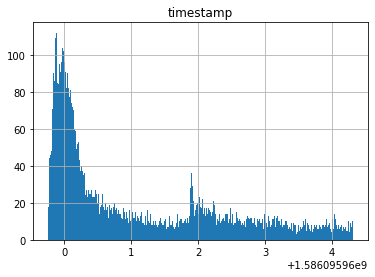

In [16]:
tact.df.hist(column='timestamp', bins=325)

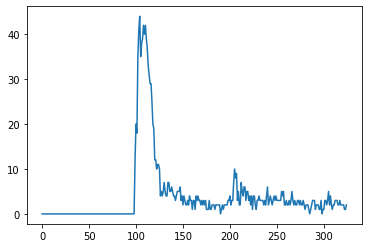

In [17]:
plt.plot(np.sum( np.sum(a, axis=0), axis=0 ))

In [18]:
video_path = '/datasets/eventdata/batch2_new/prophesee_recordings/'

In [19]:
class CameraData:
    def __init__(self, obj_name, selection="full"):
        # propophesee hyperparameters
        self.c = 2
        self.w = 200
        self.h = 250
        x0 = 180
        y0 = 0

        file_path = video_path + obj_name  # + ".start" # _td.mat
        start_time = float(open(file_path + ".start", "r").read())

        self.trajectory = read_trajectory(
            trajectory_path, obj_name, start_time=start_time, zeroed=True
        )

        traj_start, offset, self.T = selections[selection]
        self.start_t = self.trajectory[traj_start] + offset

        td_data = loadmat(file_path + "_td.mat")["td_data"]
        df = pd.DataFrame(columns=["x", "y", "polarity", "timestamp"])
        a = td_data["x"][0][0]
        b = td_data["y"][0][0]
        mask_x = (a >= 230) & (a < 430)
        mask_y = (b >= 100)
        a1 = a[mask_x & mask_y] - 230
        b1 = b[mask_x & mask_y] - 100
        df.x = a1.flatten()
        df.y = b1.flatten()
        df.polarity = td_data["p"][0][0][mask_x & mask_y].flatten()
        df.timestamp = (
            td_data["ts"][0][0][mask_x & mask_y].flatten() / 1000000.0
        )

        self.df = df
        self.threshold = 1

    def binarize(self, bin_duration):
        bin_number = int(np.floor(self.T / bin_duration))
        data_matrix = np.zeros([self.c, self.w, self.h, bin_number], dtype=int)

        pos_df = self.df[self.df.polarity == 1]
        neg_df = self.df[self.df.polarity == -1]

        end_t = self.start_t + bin_duration
        count = 0

        init_t = self.start_t

        while end_t <= self.T + init_t:  # start_t <= self.T
            _pos_count = pos_df[
                ((pos_df.timestamp >= self.start_t) & (pos_df.timestamp < end_t))
            ]
            b = pd.DataFrame(index=_pos_count.index)
            b = b.assign(
                xy=_pos_count["x"].astype(str) + "_" + _pos_count["y"].astype(str)
            )
            mask = b.xy.value_counts() >= self.threshold
            some_array = mask[mask].index.values.astype(str)
            xy = np.array(list(map(lambda x: x.split("_"), some_array))).astype(int)
            if xy.shape[0] > 0:
                data_matrix[0, xy[:, 0], xy[:, 1], count] = 1

            _neg_count = neg_df[
                ((neg_df.timestamp >= self.start_t) & (neg_df.timestamp < end_t))
            ]
            b = pd.DataFrame(index=_neg_count.index)
            b = b.assign(
                xy=_neg_count["x"].astype(str) + "_" + _neg_count["y"].astype(str)
            )
            mask = b.xy.value_counts() >= self.threshold
            some_array = mask[mask].index.values.astype(str)
            xy = np.array(list(map(lambda x: x.split("_"), some_array))).astype(int)
            if xy.shape[0] > 0:
                data_matrix[1, xy[:, 0], xy[:, 1], count] = 1

            self.start_t = end_t
            end_t += bin_duration
            count += 1

        data_matrix = np.swapaxes(data_matrix, 1, 2)

        return data_matrix

In [20]:
cam = CameraData(obj_name, selection="grasp_lift_hold")

In [21]:
cam.df.head()

,x,y,polarity,timestamp
0,172,116,1,0.000027
1,115,163,1,0.000035
2,2,159,1,0.000236
3,155,103,-1,0.000266
4,47,150,-1,0.000566


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf99829dd8>]],
      dtype=object)

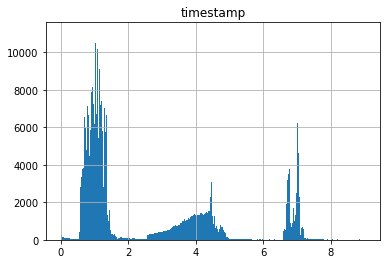

In [22]:
cam.df.hist(column='timestamp', bins=425)

In [23]:
a = cam.binarize(0.02)

In [24]:
a.shape

(2, 250, 200, 325)

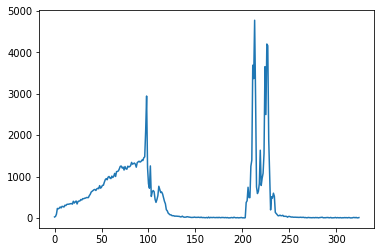

In [25]:
plt.plot( np.sum( np.sum( np.sum(a, axis=0), axis=0 ), axis=0) )

In [26]:
iters = 40

In [27]:
### count number ok spikes
tact_neg_spikes = []
tact_pos_spikes = []
cam_neg_spikes = []
cam_pos_spikes = []

tact_neg_spikes_glh = []
tact_pos_spikes_glh = []
cam_neg_spikes_glh = []
cam_pos_spikes_glh = []

for i in range(1, iters + 1):
    print(i)
    for obj in list_of_objects2:
        file_name = f"{obj}_{i:02}"
        tact_glh = TactileData(file_name, selection="grasp_lift_hold")
        cam_glh = CameraData(file_name, selection="grasp_lift_hold")
        
        tact = TactileData(file_name, selection="full")
        cam = CameraData(file_name, selection="full")
        
        tact_neg_spikes.append(tact.df[tact.df.polarity == 0].shape[0])
        tact_pos_spikes.append(tact.df[tact.df.polarity == 1].shape[0])
        
        tact_neg_spikes_glh.append(tact_glh.df[tact_glh.df.polarity == 0].shape[0])
        tact_pos_spikes_glh.append(tact_glh.df[tact_glh.df.polarity == 1].shape[0])
        
        cam_neg_spikes.append(cam.df[cam.df.polarity == -1].shape[0])
        cam_pos_spikes.append(cam.df[cam.df.polarity == 1].shape[0])
        
        cam_neg_spikes_glh.append(cam_glh.df[cam.df.polarity == -1].shape[0])
        cam_pos_spikes_glh.append(cam_glh.df[cam.df.polarity == 1].shape[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


NameError: name 'pickle' is not defined

In [28]:
from scipy.signal import savgol_filter
def smooth(_x):
    return savgol_filter(_x, 81, 1)

In [29]:
tact_spikes = np.array(tact_neg_spikes) + np.array(tact_pos_spikes)

In [52]:
import pickle
pickle.dump([tact_neg_spikes, tact_pos_spikes, tact_spikes], open('tact_spikes_count_v2.pk', 'wb'))

In [40]:
a = smooth(tact_neg_spikes) / smooth(tact_pos_spikes)

In [42]:
a

array([1.8805906 , 1.88530159, 1.89004994, 1.8948361 , 1.89966051,
       1.90452364, 1.90942596, 1.91436794, 1.91935007, 1.92437283,
       1.92943673, 1.93454227, 1.93968997, 1.94488036, 1.95011395,
       1.95539131, 1.96071298, 1.96607952, 1.97149149, 1.97694949,
       1.98245409, 1.9880059 , 1.99360553, 1.9992536 , 2.00495074,
       2.01069759, 2.01649481, 2.02234306, 2.02824301, 2.03419536,
       2.04020081, 2.04626007, 2.05237386, 2.05854294, 2.06476804,
       2.07104994, 2.07738942, 2.08378727, 2.09024431, 2.09676135,
       2.10333924, 2.10395838, 2.09420312, 2.09520961, 2.1063835 ,
       2.11264433, 2.10743411, 2.10735198, 2.10814215, 2.10538144,
       2.12288814, 2.11866684, 2.11539572, 2.12219022, 2.12058126,
       2.14756758, 2.14640127, 2.14731882, 2.1521342 , 2.15667993,
       2.15729149, 2.15782975, 2.15240581, 2.16176862, 2.16380055,
       2.16818208, 2.16724504, 2.16654235, 2.16341908, 2.15640638,
       2.17313151, 2.1700095 , 2.17964211, 2.16648059, 2.17472

[]

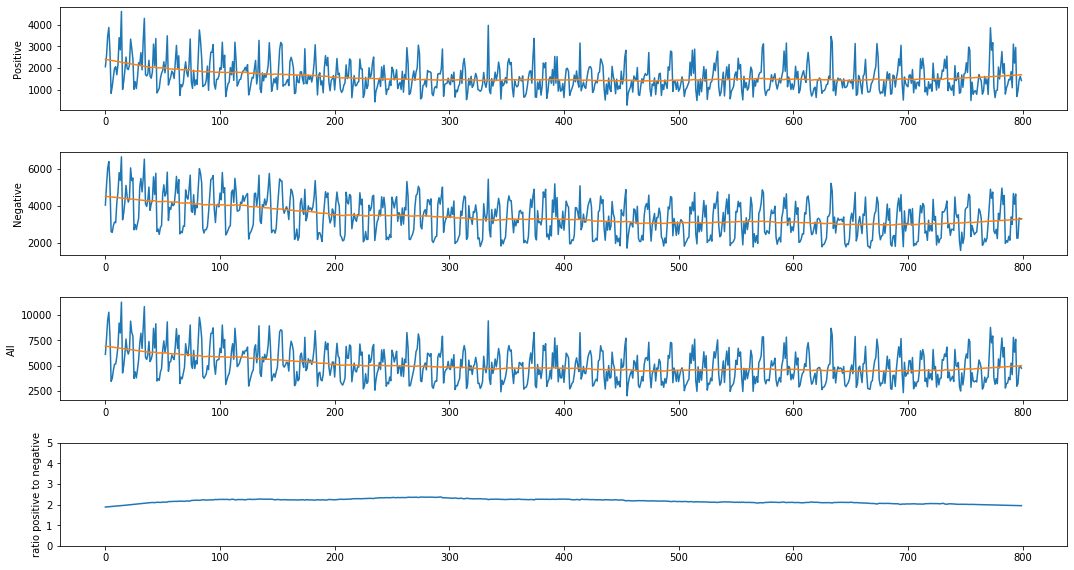

In [46]:
fig, ax = plt.subplots(4, figsize=(15,8))

ax[0].plot(tact_pos_spikes)
ax[0].plot( smooth(tact_pos_spikes) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes)
ax[1].plot( smooth(tact_neg_spikes) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes)
ax[2].plot( smooth(tact_spikes) )
ax[2].set_ylabel('All')

ax[3].plot( a )
ax[3].set_ylabel('ratio positive to negative')
ax[3].set_ylim([0,5])

plt.tight_layout(True)
fig.savefig("tactile_full.png")

plt.plot()

In [31]:
tact_spikes_glh = np.array(tact_neg_spikes_glh) + np.array(tact_pos_spikes_glh)

[]

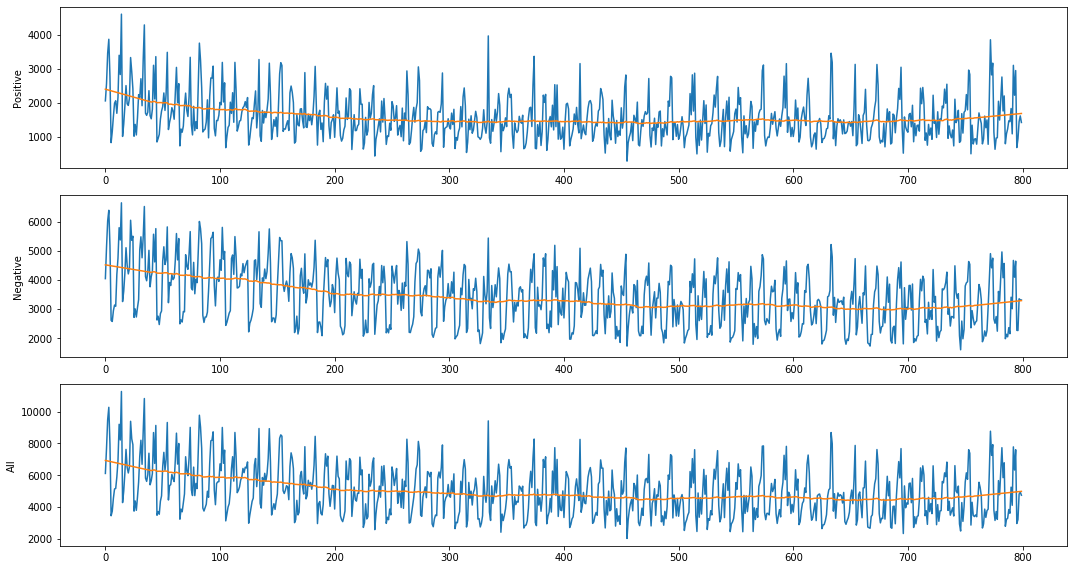

In [32]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(tact_pos_spikes_glh)
ax[0].plot( smooth(tact_pos_spikes_glh) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes)
ax[1].plot( smooth(tact_neg_spikes) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes)
ax[2].plot( smooth(tact_spikes) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("tactile_glh.png")

plt.plot()

In [33]:
cam_spikes = np.array(cam_neg_spikes) + np.array(cam_pos_spikes)

[]

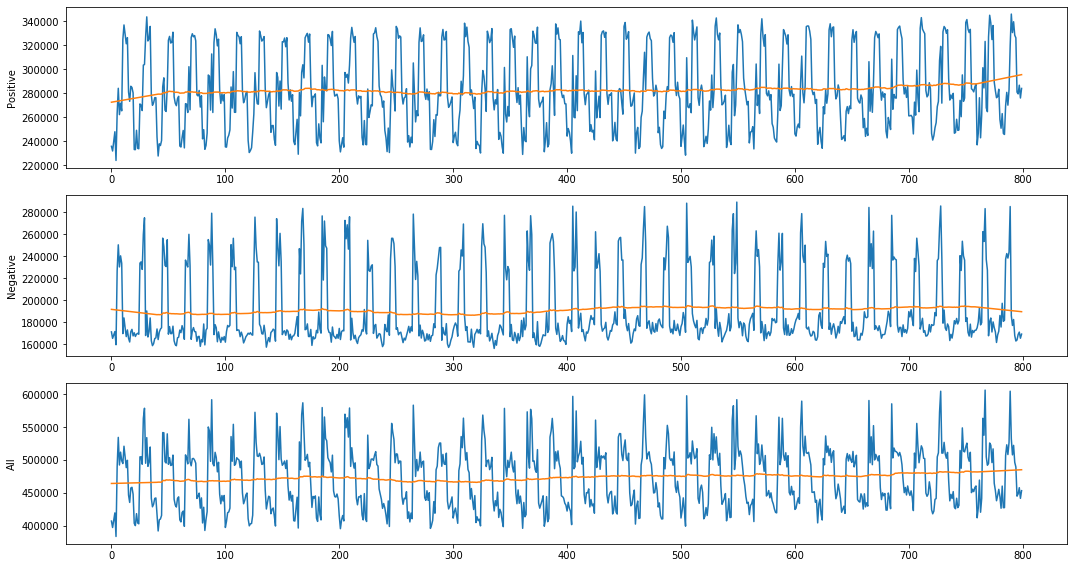

In [35]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(cam_pos_spikes)
ax[0].plot( smooth(cam_pos_spikes) )
ax[0].set_ylabel('Positive')

ax[1].plot(cam_neg_spikes)
ax[1].plot( smooth(cam_neg_spikes) )
ax[1].set_ylabel('Negative')

ax[2].plot(cam_spikes)
ax[2].plot( smooth(cam_spikes) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("vision_full.png")

plt.plot()

In [36]:
cam_spikes_glh = np.array(cam_neg_spikes_glh) + np.array(cam_pos_spikes_glh)

[]

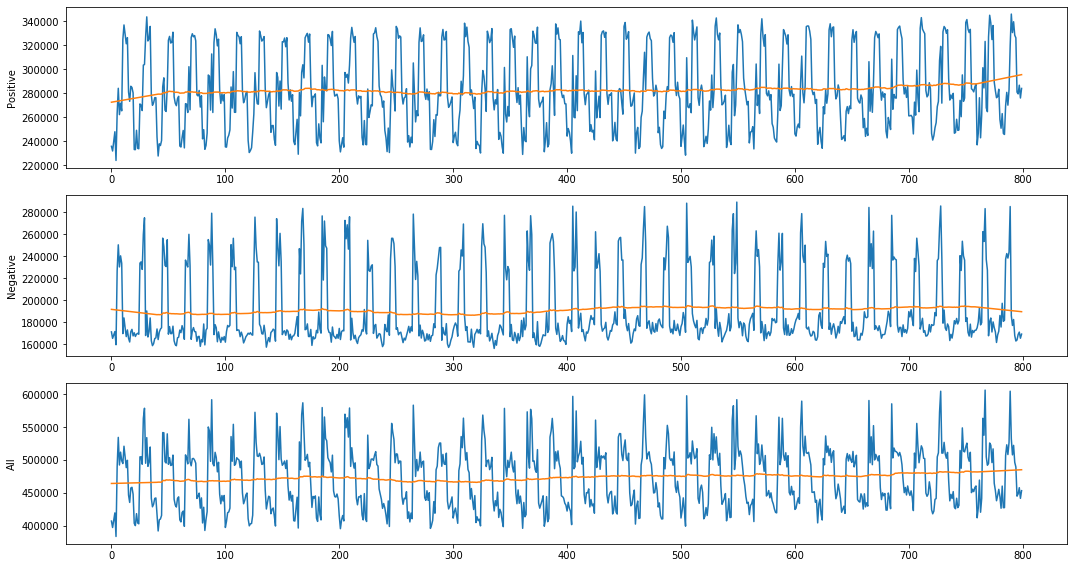

In [37]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(cam_pos_spikes_glh)
ax[0].plot( smooth(cam_pos_spikes_glh) )
ax[0].set_ylabel('Positive')

ax[1].plot(cam_neg_spikes_glh)
ax[1].plot( smooth(cam_neg_spikes_glh) )
ax[1].set_ylabel('Negative')

ax[2].plot(cam_spikes_glh)
ax[2].plot( smooth(cam_spikes_glh) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("vision_glh.png")

plt.plot()